### Import neccessary Libraries and utilities functions

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.7 MB/s eta 0:00:00


In [2]:
import gc
from datetime import datetime
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import sklearn
import catboost
import lightgbm

# Other Libraries
from sklearn.model_selection import (StratifiedShuffleSplit, KFold, StratifiedKFold, train_test_split,
                                        cross_val_score, GridSearchCV, ShuffleSplit, learning_curve, cross_val_predict)
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,
                             classification_report, roc_curve, roc_auc_score, confusion_matrix)
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import warnings
from sklearn import utils
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE




In [ ]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if 1 < nunique[col] < 50]]  # Pick columns with unique values between 1 and 50
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int(np.ceil(nCol / nGraphPerRow))
    plt.figure(figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(columnDf.dtype, np.number):
            valueCounts = columnDf.value_counts()
            ax = valueCounts.plot.bar()
            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
        else:
            ax = columnDf.hist()
            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')

    plt.tight_layout(pad=1, w_pad=1, h_pad=1)
    plt.show()

In [ ]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number])
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

### Load Data

In [3]:
!pip install -q gdown

import gdown
import pandas as pd
import hashlib

shared_link = 'https://drive.google.com/file/d/1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH/view?usp=sharing'

file_id = shared_link.split('/')[-2]
dataset_path = 'https://drive.google.com/uc?id=' + file_id

# Download the file
output = '/content/creditcard.csv'
gdown.download(dataset_path, output, quiet=False)

# Read the CSV file
data = pd.read_csv(output)
data.dataframeName = 'creditcard.csv'
nRow, nCol = data.shape

# Print the number of rows and columns
print(f'There are {nRow} rows and {nCol} columns')

Downloading...
From (original): https://drive.google.com/uc?id=1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH
From (redirected): https://drive.google.com/uc?id=1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH&confirm=t&uuid=d34ae854-30ab-49e7-8613-2107d40aa7f4
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:02<00:00, 63.1MB/s]


There are 284807 rows and 31 columns


### Oversampling

In [4]:
# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

data.insert(0, 'scaled_amount', rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1)))
data.insert(1, 'scaled_time', rob_scaler.fit_transform(data['Time'].values.reshape(-1,1)))

data.drop(['Time','Amount'], axis=1, inplace=True)

# Amount and Time are Scaled!
data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [5]:
X = data.drop('Class', axis=1)
y = data['Class']
seed = 42
sss = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Convert numpy arrays to pandas DataFrame
original_Xtrain = pd.DataFrame(original_Xtrain, columns=X.columns)
original_Xtest = pd.DataFrame(original_Xtest, columns=X.columns)

In [6]:
original_ytrain = pd.DataFrame(original_ytrain, columns = ["Class"])
original_ytest = pd.DataFrame(original_ytest, columns = ["Class"])

In [7]:
ref_data = pd.concat([original_Xtrain, original_ytrain], axis = 0)
current_data = pd.concat([original_Xtest, original_ytest], axis = 0)

#### Oversampling using SMOTE

In [8]:
X = data.drop('Class', axis=1)
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Combine resampled data into a new dataframe
new_df = pd.concat([pd.DataFrame(X_train_resampled), pd.DataFrame(y_train_resampled, columns=['Class'])], axis=1)

# Check the shape of the new dataframe
print(new_df.shape)

(454902, 31)


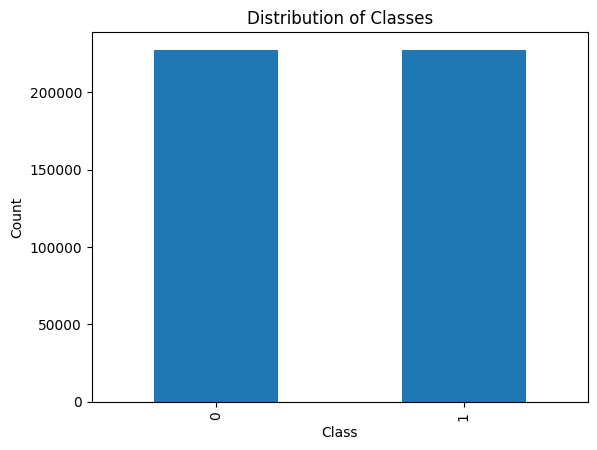

In [9]:

class_counts = new_df['Class'].value_counts()
class_counts.plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


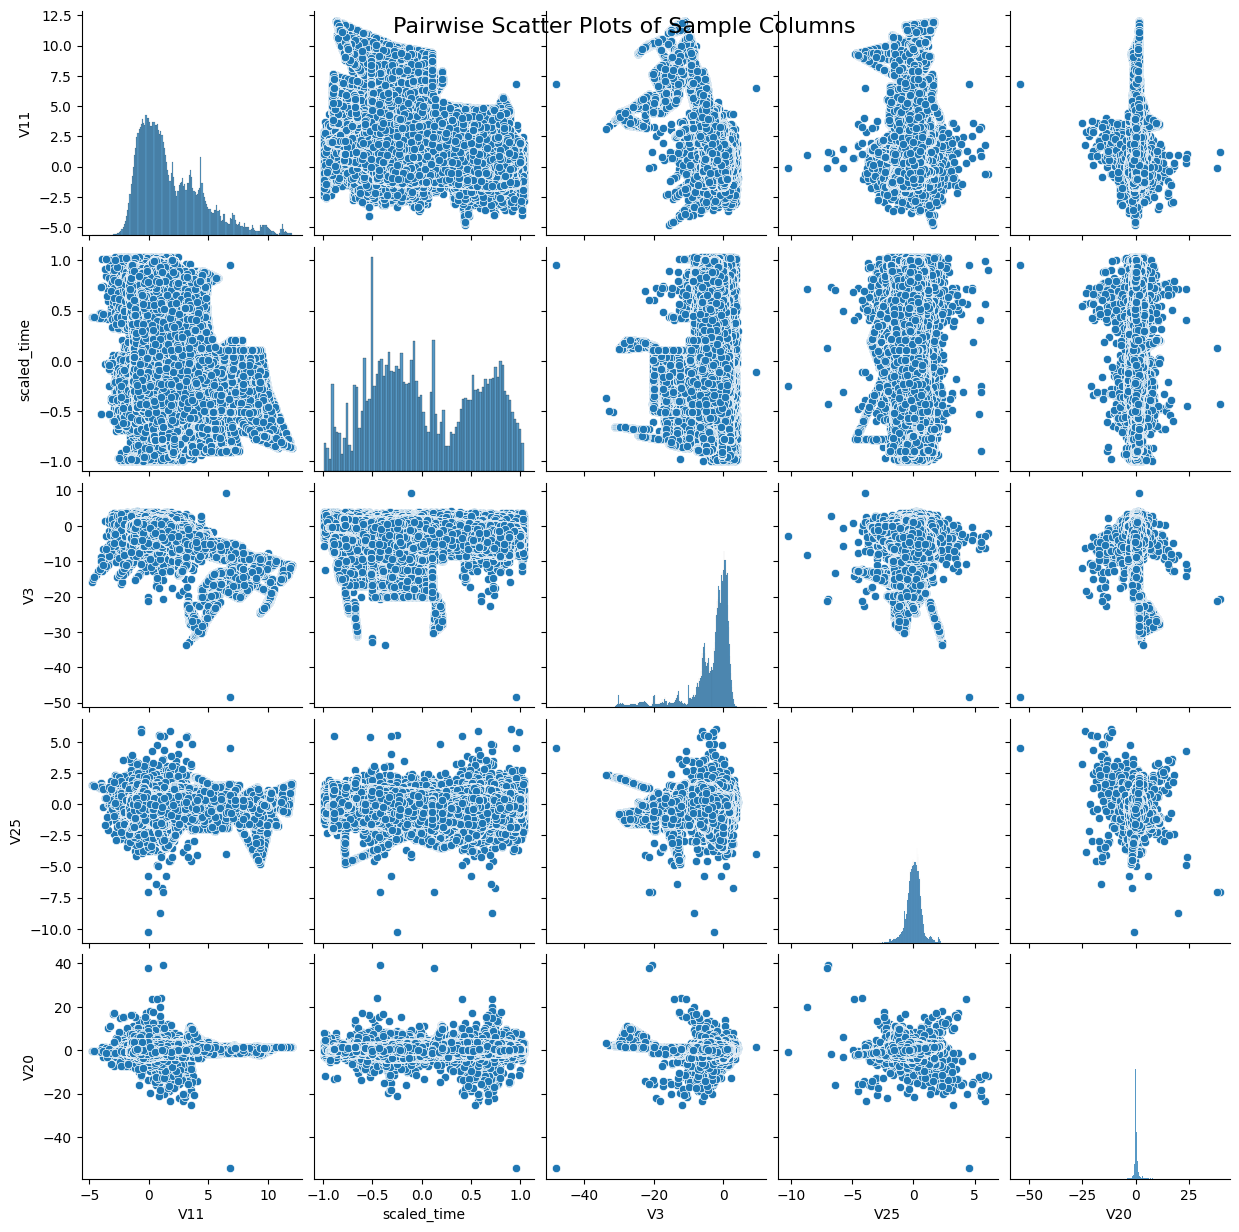

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample a subset of columns for pairwise scatter plots
sample_columns = new_df.sample(5, axis=1)  # You can adjust the number of columns to sample

sns.pairplot(sample_columns, kind='scatter')
plt.suptitle('Pairwise Scatter Plots of Sample Columns', fontsize=16)
plt.show()


In [13]:
import plotly.graph_objects as go
import numpy as np

# Function to create heatmap plotly figure
def create_heatmap(data, title):
    fig = go.Figure(data=go.Heatmap(
        z=data.values,
        x=data.columns,
        y=data.index,
        colorscale='Viridis'))

    fig.update_layout(title=title,
                      xaxis_title='Features',
                      yaxis_title='Features')

    return fig

# Entire DataFrame
corr = data.corr()
fig1 = create_heatmap(corr, "Imbalanced Correlation Matrix (don't use for reference)")

# Subsample DataFrame
sub_sample_corr = new_df.corr()
print(new_df.shape)
fig2 = create_heatmap(sub_sample_corr, 'SubSample Correlation Matrix (use for reference)')

# Display the figures
fig1.show()
fig2.show()


(454902, 31)


In [14]:
target = 'Class'
predictors = ['scaled_time', 'scaled_amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

In [15]:
clf = RandomForestClassifier()

In [16]:
VALID_SIZE = 0.20
TEST_SIZE = 0.20

NUMBER_KFOLDS = 5

# Other settings
RANDOM_STATE = 2024

train_df, test_df = train_test_split(new_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [17]:
clf.fit(train_df[predictors], train_df[target].values)
preds = clf.predict(valid_df[predictors])

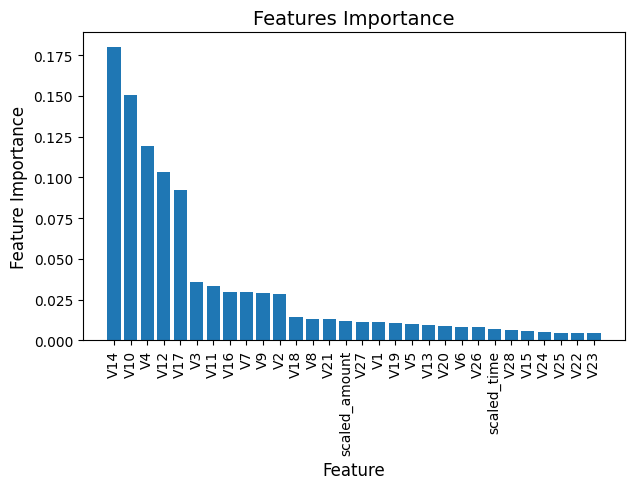

In [18]:
# Create a DataFrame with feature names and their importance scores
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})

# Sort the DataFrame by feature importance in descending order
tmp = tmp.sort_values(by='Feature importance',ascending=False)

# Create a figure and axis object
plt.figure(figsize = (7,4))

# Plotting the bar chart
plt.bar(tmp['Feature'], tmp['Feature importance'])

# Adding title and labels
plt.title('Features Importance', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)

# Rotating x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()


Since we already oversampled the dataset, there is no need to run and fit the model multiple time to get a relaiable feature importance.


Checking if we could drop features

In [19]:
from scipy.stats import ttest_ind

# Perform t-test for each column
t_values = []
p_values = []
results = []

for col in ['V25', 'V24', 'V26', 'V28']:
    t_stat, p_val = ttest_ind(new_df[col], new_df['Class'])
    t_values.append(t_stat)
    p_values.append(p_val)

    # Determine if we reject or accept the null hypothesis
    if p_val < 0.05:
        results.append('Reject Null the Hypothesis')
    else:
        results.append('Accept Null the Hypothesis')

result_table = pd.DataFrame({
    'Column Name': ['V25', 'V24', 'V26', 'V28'],
    't-value': t_values,
    'p-value': p_values,
    'Reject Null or Accept Null': results
})

result_table.to_csv('q4.csv', index = False)

In [20]:
result_table

,Column Name,t-value,p-value,Reject Null or Accept Null
0,V25,-397.878902,0.0,Reject Null the Hypothesis
1,V24,-509.298990,0.0,Reject Null the Hypothesis
2,V26,-488.901646,0.0,Reject Null the Hypothesis
3,V28,-463.157083,0.0,Reject Null the Hypothesis


###### Interpretation of the Results
- t-value: A high absolute t-value indicates that the feature is significantly different from what would be expected under the null hypothesis.
- p-value: A very low p-value (typically < 0.05) indicates strong evidence against the null hypothesis, meaning the feature is statistically significant.
- Reject Null: If the null hypothesis is rejected, it suggests that the feature is significantly different from zero and should be considered important.
###### Why We Can’t Reject Features
- Statistical Significance: The features V25, V24, V26, and V28 all have very low p-values (much lower than 0.05), which means there is strong evidence against the null hypothesis for each feature. This indicates that these features are statistically significant.

- Feature Importance: In the context of a model, features with significant p-values contribute important information. Rejecting these features could lead to a loss of valuable information that the model needs to make accurate predictions.

- Reject Null Hypothesis: Since the null hypothesis (that the feature has no effect) is rejected for all listed features, it implies that these features do indeed have an effect and are important. Therefore, instead of rejecting these features, they should be retained in the model.



In [22]:
classifiers = {
    "Random Jungle": RandomForestClassifier(),
    "CatBoost" : CatBoostClassifier(verbose = 0),
    "LGBM" : LGBMClassifier()
}

In [23]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

Classifiers:  RandomForestClassifier Have a training ROC_AUC , Accuracy, Recall & Precision score of 0.99 1.0 0.97 0.98
Classifiers:  RandomForestClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.99 1.0 0.96 0.96


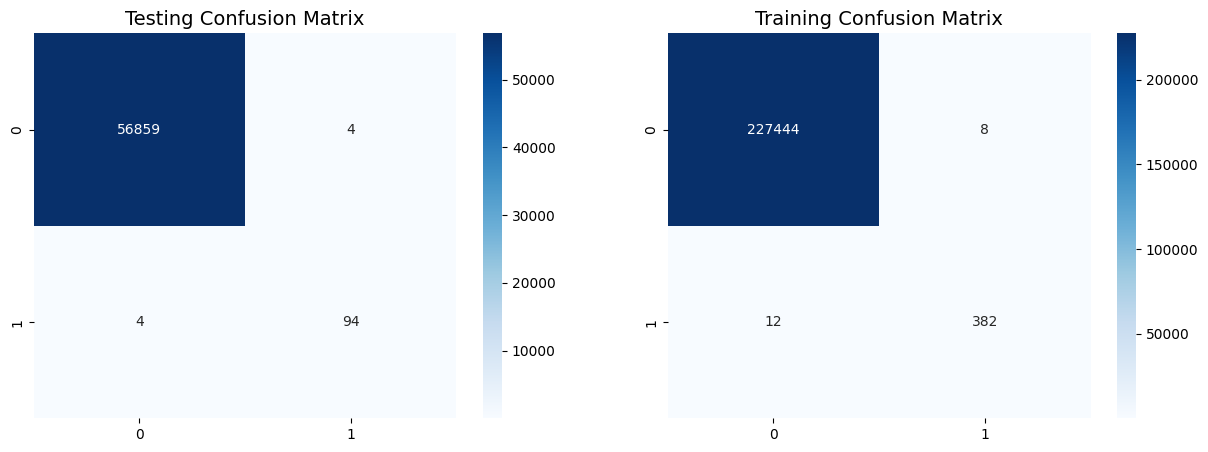

Classifiers:  CatBoostClassifier Have a training ROC_AUC , Accuracy, Recall & Precision score of 1.0 1.0 0.97 0.8
Classifiers:  CatBoostClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 1.0 1.0 0.96 0.73


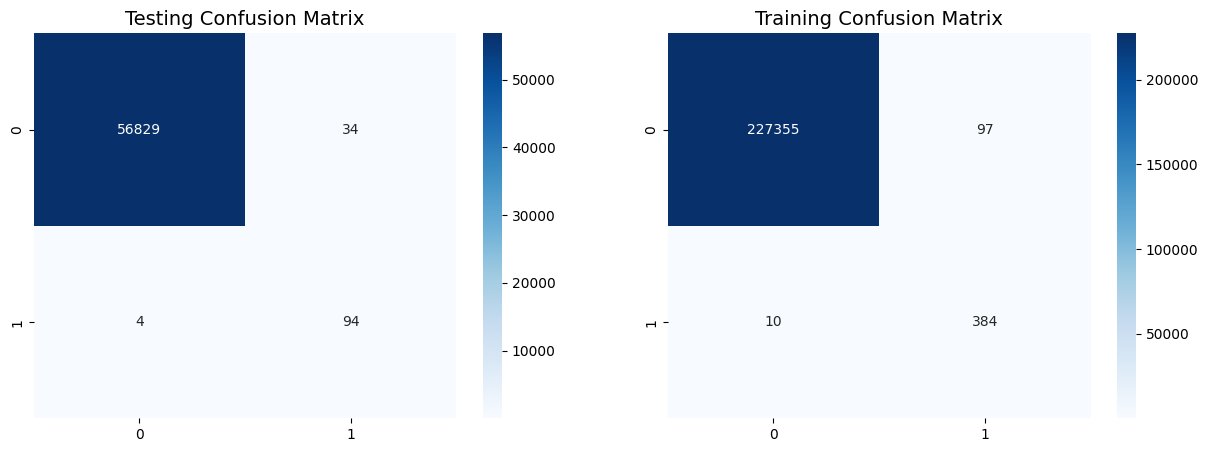

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Classifiers:  LGBMClassifier Have a training ROC_AUC , Accuracy, Recall & Precision score of 0.99 1.0 0.97 0.64
Classifiers:  LGBMClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.99 1.0 0.97 0.63


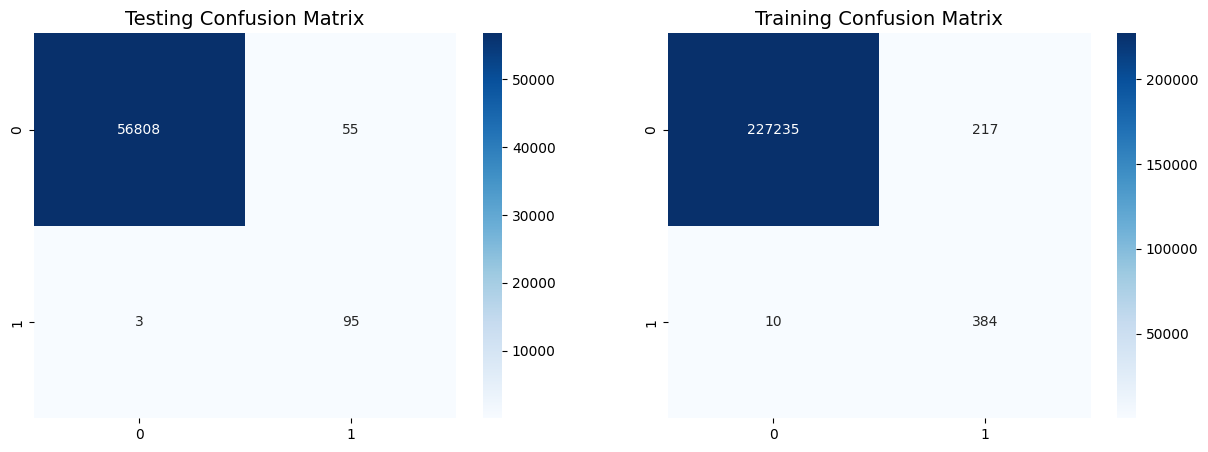

In [24]:
for key, classifier in classifiers.items():
    classifier.fit(X, y)
    original_ypred_train = classifier.predict_proba(original_Xtrain)[:,1]
    original_ypred_test = classifier.predict_proba(original_Xtest)[:,1]

    train_roc_auc = roc_auc_score(original_ytrain, original_ypred_train)
    test_roc_auc = roc_auc_score(original_ytest, original_ypred_test)

    original_ypred_train = [1 if x >= 0.5 else 0 for x in original_ypred_train]
    original_ypred_test = [1 if x >= 0.5 else 0 for x in original_ypred_test]

    # Calculate scores
    train_accuracy = accuracy_score(original_ytrain , original_ypred_train)
    train_recall = recall_score(original_ytrain, original_ypred_train)
    train_precision = precision_score(original_ytrain, original_ypred_train)

    test_accuracy = accuracy_score(original_ytest, original_ypred_test)
    test_recall = recall_score(original_ytest, original_ypred_test)
    test_precision = precision_score(original_ytest, original_ypred_test)

    print("Classifiers: ", classifier.__class__.__name__,
          "Have a training ROC_AUC , Accuracy, Recall & Precision score of",
          round(train_roc_auc, 2),
          round(train_accuracy, 2),
          round(train_recall, 2),
          round(train_precision, 2))

    print("Classifiers: ", classifier.__class__.__name__,
          "Have a testing ROC_AUC , Accuracy , Recall & Precision score of",
          round(test_roc_auc, 2),
          round(test_accuracy, 2),
          round(test_recall, 2),
          round(test_precision, 2))

    # Continue with confusion matrix plotting
    cm = confusion_matrix(original_ytest, original_ypred_test)
    cm2 = confusion_matrix(original_ytrain, original_ypred_train)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    sns.heatmap(cm,
                annot=True, ax=ax1,
                fmt='d', cmap="Blues")
    ax1.set_title('Testing Confusion Matrix', fontsize=14)
    sns.heatmap(cm2,
                annot=True, ax=ax2,
                fmt='d', cmap="Blues")
    ax2.set_title('Training Confusion Matrix', fontsize=14)
    plt.show()

Model Performance Analysis --------------------------
### RandomForestClassifier
* **Training Scores:**
* **ROC\_AUC:** 0.99
* **Accuracy:** 1.0
* **Recall:** 0.97
* **Precision:** 0.98
* **Testing Scores:**
* **ROC\_AUC:** 0.99
* **Accuracy:** 1.0
* **Recall:** 0.96
* **Precision:** 0.96
The `RandomForestClassifier` performs exceptionally well on both training and testing sets, indicating good generalization. The ROC\_AUC and Accuracy are both very high, suggesting the model is highly capable of distinguishing between classes. The Recall and Precision are also high, with only a slight drop in testing performance, indicating that the model is both sensitive to detecting the positive class and precise in its predictions.
### CatBoostClassifier
* **Training Scores:**
* **ROC\_AUC:** 1.0
* **Accuracy:** 1.0
* **Recall:** 0.97
* **Precision:** 0.8
* **Testing Scores:**
* **ROC\_AUC:** 1.0
* **Accuracy:** 1.0
* **Recall:** 0.96
* **Precision:** 0.73
The `CatBoostClassifier` achieves perfect ROC\_AUC and Accuracy on both training and testing sets, indicating excellent performance in distinguishing between classes. However, the Precision is notably lower compared to Recall, especially in the testing set. This suggests that while the model is very good at detecting the positive class (high Recall), it has a higher rate of false positives (lower Precision).
### LGBMClassifier
* **Training Scores:**
* **ROC\_AUC:** 0.99
* **Accuracy:** 1.0
* **Recall:** 0.97
* **Precision:** 0.64
* **Testing Scores:**
* **ROC\_AUC:** 0.99
* **Accuracy:** 1.0
* **Recall:** 0.97
* **Precision:** 0.63
The `LGBMClassifier` also performs very well with high ROC\_AUC and Accuracy on both training and testing sets. However, similar to the `CatBoostClassifier`, it exhibits a significantly lower Precision compared to Recall. This indicates that while the model is effective in identifying the positive class (high Recall), it suffers from a higher proportion of false positives (low Precision).
### Summary
* All three classifiers show excellent performance in terms of ROC\_AUC and Accuracy, suggesting strong capabilities in distinguishing between classes and correctly classifying the majority of samples.
* `RandomForestClassifier` demonstrates a balanced performance between Recall and Precision, making it a reliable model in terms of both detecting positive instances and minimizing false positives.
* Both `CatBoostClassifier` and `LGBMClassifier` show high Recall but lower Precision, indicating a tendency to predict more false positives. These results suggest that while all models are robust, `RandomForestClassifier` might be the most balanced choice in scenarios where both Recall and Precision are critical. `CatBoostClassifier` and `LGBMClassifier` may require further tuning or post-processing to improve Precision.”


